In [2]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
graph_builder = StateGraph(State)

In [4]:
# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")
# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
graph = graph_builder.compile()

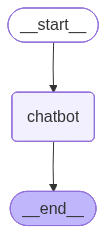

In [5]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# グラフの実行
response = graph.invoke({"messages": [("user", "光の三原色は？")]})

# 言語モデルからの回答のみを表示
print(response["messages"][-1].content)

光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの色を組み合わせることで、さまざまな色を作り出すことができます。この原理は、RGBカラーシステムとして広く使用されています。


In [9]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            print("回答:", value["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)

質問: 光の三原色は？
回答: 光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの三色の光を組み合わせることで、さまざまな色を表現することができます。この原理は、ディスプレイやテレビなどのデジタル画像表示に広く利用されています。
ありがとうございました!


In [7]:
from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
memory_graph = graph_builder.compile(checkpointer=memory)

In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！どういったことをお手伝いできますか？
ありがとうございました!
